# Import data
Import data downloaded from lantmäteriet (https://geotorget.lantmateriet.se/geodataprodukter/markhojdmodell-nedladdning-grid-50)

In [1]:
import numpy as np

from storm_water_management import utils

tif_filename = r"/home/chris/projects/ifk-storm-water-management/data/64_3_2023.tif"
tfw_filename = tif_filename.split(".")[0] + r".tfw"

elevation_data = utils.get_elevation_data_from_tif(tif_filename)
tfw = utils.get_coordinates_from_tfw(tfw_filename)

elev_max = np.amax(elevation_data)


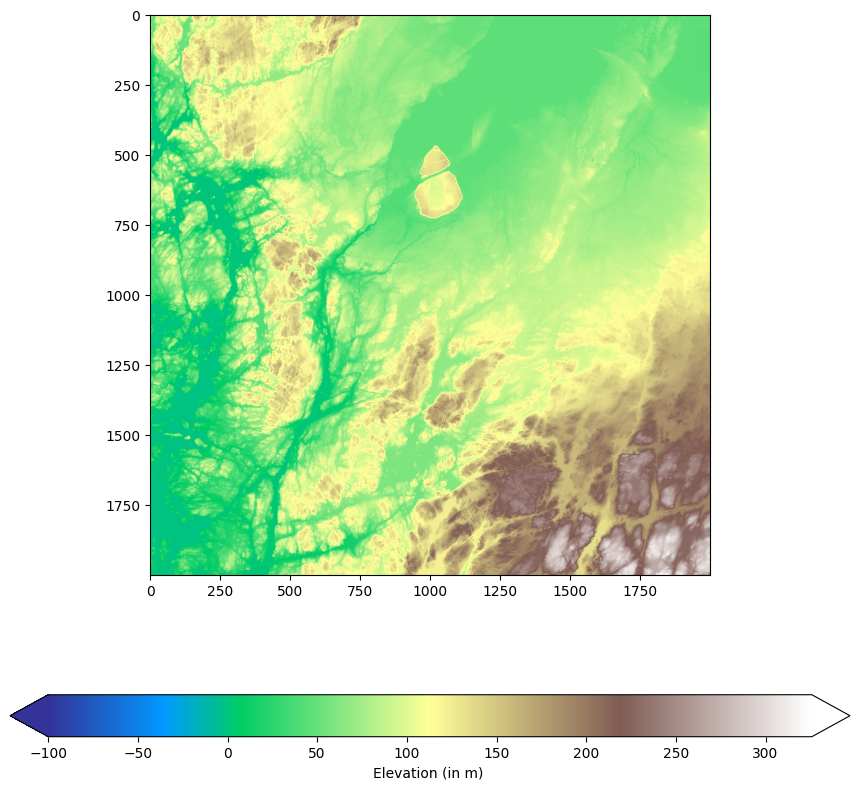

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[12,8])
ax = fig.add_axes([0, 0, 1, 1])
raster_image=ax.imshow(elevation_data,cmap="terrain",vmax=elev_max,vmin=-100)
fig.colorbar(raster_image, ax=ax,label="Elevation (in m) ",orientation='horizontal',extend='both',shrink=0.7)
plt.show()



# Calculate accumulated flow
Using richdem, calculate acumulated flow. Use D8 algorithm, i.e., use 8 directions for each cell (diagonal cells are included.)

On flat areas, fill depressions with small gradient. Otherwise the flow will be difficult to calculate in these areas. Another approch is to use canals. 

How to handle water, like lakes and oceans? 

Need to set geodata to dem file. Maybe we need to import using gdal instead of using richddems wrapper. 

In [2]:
import richdem as rd

dem = rd.LoadGDAL(tif_filename, no_data=-9999)

#Fill depressions with epsilon gradient to ensure drainage
rd.FillDepressions(dem, epsilon=True, in_place=True)

#Get flow accumulation with no explicit weighting. The default will be 1.
accum_d8 = rd.FlowAccumulation(dem, method='D8')



A Priority-Flood+Epsilon
C Barnes, R., Lehman, C., Mulla, D., 2014. Priority-flood: An optimal depression-filling and watershed-labeling algorithm for digital elevation models. Computers & Geosciences 62, 117–127. doi:10.1016/j.cageo.2013.04.024

c topology = D8
p Setting up boolean flood array matrix...
p Adding cells to the priority queue...
p Performing Priority-Flood+Epsilon...
t succeeded in 1.87844 s======================] (100% - 0.0s - 1 threads)
m Cells processed = 4000000
m Cells in pits = 777150
W W In assigning negligible gradients to depressions, some depressions rose above the surrounding cells. This implies that a larger storage type should be used. The problem occured for 2781 of 4000000.

A O'Callaghan (1984)/Marks (1984) D8/D4 Flow Accumulation
C O'Callaghan, J.F., Mark, D.M., 1984. The Extraction of Drainage Networks from Digital Elevation Data. Computer vision, graphics, and image processing 28, 323--344.

c topology = D8
[==========================================

In [3]:
coordinates = utils.get_coordinate_center_points_from_tfw(tfw, elevation_data, accum_d8, 200, 200)
print(coordinates)

[{"geometry": {"coordinates": [300050.0, 6500000.0], "type": "Point"}, "properties": {"elevation_data": 102.80465698242188, "water_flow": 2.0}, "type": "Feature"}, {"geometry": {"coordinates": [300100.0, 6500000.0], "type": "Point"}, "properties": {"elevation_data": 106.27117919921875, "water_flow": 1.0}, "type": "Feature"}, {"geometry": {"coordinates": [300150.0, 6500000.0], "type": "Point"}, "properties": {"elevation_data": 107.15628814697266, "water_flow": 1.0}, "type": "Feature"}, {"geometry": {"coordinates": [300200.0, 6500000.0], "type": "Point"}, "properties": {"elevation_data": 102.40780639648438, "water_flow": 1.0}, "type": "Feature"}, {"geometry": {"coordinates": [300250.0, 6500000.0], "type": "Point"}, "properties": {"elevation_data": 97.380126953125, "water_flow": 3.0}, "type": "Feature"}, {"geometry": {"coordinates": [300300.0, 6500000.0], "type": "Point"}, "properties": {"elevation_data": 94.51130676269531, "water_flow": 1.0}, "type": "Feature"}, {"geometry": {"coordinate

                     geometry  elevation_data  water_flow
0      POINT (300050 6500000)      102.804657         2.0
1      POINT (300100 6500000)      106.271179         1.0
2      POINT (300150 6500000)      107.156288         1.0
3      POINT (300200 6500000)      102.407806         1.0
4      POINT (300250 6500000)       97.380127         3.0
...                       ...             ...         ...
39995  POINT (309800 6509950)       98.449181         2.0
39996  POINT (309850 6509950)       98.258202       258.0
39997  POINT (309900 6509950)       97.736641       605.0
39998  POINT (309950 6509950)       98.299469         7.0
39999  POINT (310000 6509950)      101.190247       165.0

[40000 rows x 3 columns]


<Axes: >

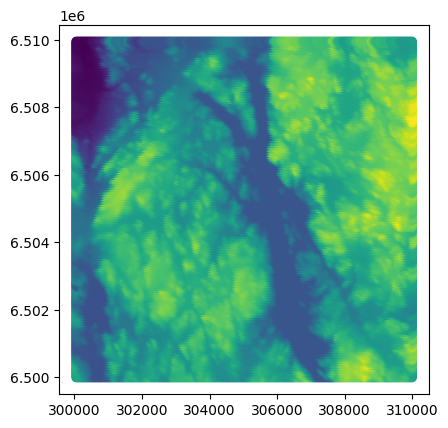

In [4]:
import geopandas

df = geopandas.GeoDataFrame.from_features(coordinates)
print(df)
df.plot(df["elevation_data"])

/home/chris/projects/ifk-storm-water-management/.venv/lib/python3.10/site-packages/richdem/__init__.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


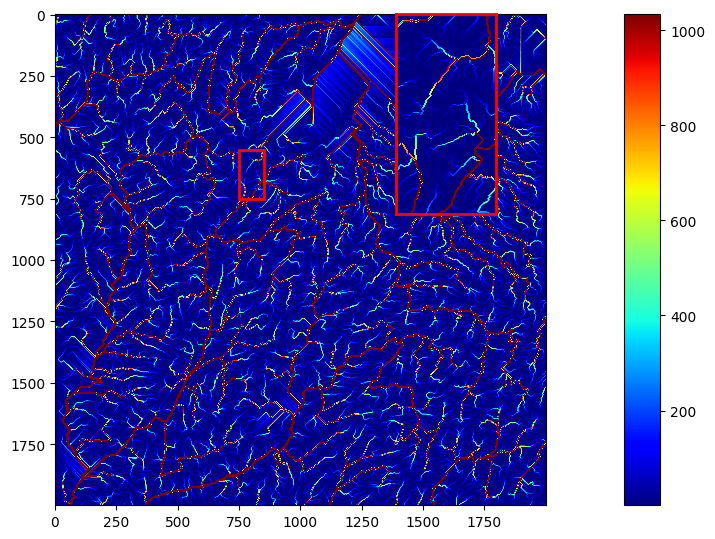

In [5]:
d8_fig = rd.rdShow(accum_d8, zxmin=750, zxmax=850, zymin=750, zymax=550, figsize=(8,5.5), cmap='jet')

In [ ]:
dem = rd.LoadGDAL(tif_filename, no_data=-9999)
dem.geotransform

In [ ]:
import rasterio
from rasterio.enums import Resampling

upscale_factor = 2

with rasterio.open(tif_filename) as dataset:

    # resample data to target shape
    data = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling=Resampling.bilinear  # will not keep the original val on points
    )

    # scale image transform
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )
# [102.80466, 106.27118, 107.15629, 102.40781, 97.38013]
# data[0][0][0:5]

rda = rd.rdarray(data[0], no_data=-9999)

# kolla hur det förhåller sig med -9999 vid interpolering
rda_fill = rd.FillDepressions(rda, in_place=False)
fill_fig = rd.rdShow(rda_fill - rda, zxmin=750, zxmax=850, zymin=750, zymax=550, figsize=(8,5.5), cmap='jet')